# Practical Session 3 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from copy import deepcopy

from tictactoe_env import TicTacToeEnv, DRAW
from utils import play, Agent, agent_vs_agent

from forban import *
from forban.bandits import NormalBandit, Normal
from forban.sequentialg import SequentiAlg
from forban.utils import *

# Part I - Best Arm Identification

### Question 0

Recall the `forban` module.

### Question 1

What are the three main parts of an exploration algorithm that aims to identify the best arm (*i.e.*, the arm having the largest mean).

### Exploration class template

In [ ]:
class Exploration(SequentiAlg):
    def __init__(self, bandit, name="Exploration", params={'init': 0, 'stoping criterion': None }):
        SequentiAlg.__init__(self, bandit, name=name, params=params)
        self.stoping_criterion = params['stoping criterion']
        
    def compute_indices(self):
        pass
            
    def choose_an_arm(self):
        return randamax(self.indices)
    
    def sampling(self):
        _ = self.pull(self.choose_an_arm())
    
    def recommendation(self):
        pass
    
    def stop(self):
        pass
    
    def run(self):
        while not self.stop():
            self.sampling()
            self.recommendation()
            
    def fit(self, experiment, reset=True):
        if reset:
            self.reset()
        self.run()
        arm = self.recommendation()
        r = self.bandit.regrets[arms]
        experiment(arm, r)

In [ ]:
########################################
#             Experiments              #
########################################

class Experiment:
    def __init__(self, sequential_algorithms, bandit,
                 statistics={'distance':True, 'proba':True}):
        assert len(sequential_algorithms) > 0
        self.algorithms = sequential_algorithms
        self.bandit = bandit
        self.nbr_algo = len(sequential_algorithms)
        self.algo_idx = 0
        self.statistics = {}
        self.nbr_exp = None
        for algo_idx, algo in enumerate(self.algorithms):
            self.statistics[algo_idx] = {'name': algo.name}
            for s in statistics.items():
                if s[1]:
                    self.statistics[algo_idx][s[0]] = None
        stats = self.statistics[0].keys()
        self.stats = stats
        
    def __call__(self, arm, r):
        self.reco_arm = arm
        self.delta = r

    def run(self, nbr_exp=500):
        self.nbr_exp = nbr_exp
        for algo_idx, algo in enumerate(self.algorithms):
            reco_arms = np.zeros(nbr_exp, int)
            delta = np.zeros(nbr_exp)
            for i in range(nbr_exp):
                
                algo.fit(horizon, experiment=self)
                
                reco_arms[i] = self.reco_arm
                delta[i] = self.delta
            
            for k in self.stats:
                if k == 'distance':
                    self.statistics[algo_idx][k] = delta.copy()
                elif k == 'proba':
                    self.statistics[algo_idx][k] = reco_arm.copy()
                    
    def plot(self):
        exp_info = f"Nbr. of experiments = {self.nbr_exp}"
        ticks = np.arange(self.bandit.nbr_arms)
        if 'proba' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arms", fontsize=14)
            for algo_stats in self.statistics.values():
                name = algo_stats['name']
                delta = algo_stats['proba']
                plt.bar(ticks, delta, width=0.4, tick_label=[str(i) for i in range(bandit.nbr_arms)], label = name, alpha=0.5)
    
            plt.legend()
            plt.show()
            plt.close()
            
        ticks = np.arange(self.bandit.nbr_arms)
        if 'proba' in self.stats:
            plt.figure(figsize=(12,5))
            title = "Histogram of recommendation regret\n"
            title += exp_info
            plt.title(title)
            plt.xlabel("Arms", fontsize=14)
            for algo_stats in self.statistics.values():
                name = algo_stats['name']
                delta = algo_stats['distance']
                plt.hist(delta, label = name, alpha=0.5)
    
            plt.legend()
            plt.show()
            plt.close()

### Question 3
Using the `Exploration` class, implement an exploration algorithm with uniform allocation. Test different recommendation rules on different bandit problem (having different complexities as defined in the previous homework).

### Question 4
Using the `Exploration` class, implement an UCB like exploration algorithm. Test different recommendation rules on different bandit problems (having different complexities as defined two sessions ago).

### Question 5
Using the `Exploration` class, implement the sequential halving algorithm with a fixed budget. Test it on different bandit problems (having different complexities as defined two sessions ago).

### Question 6
Do you think using structure would help for BAI?

# Part II -  Monte Carlo Tree Search

In this practical session, we will implement several MCTS heuristics and compare them. To do so, we will use a  Tic Tac Toe environement.

### Question 1
Recall and explain the idea behind MCTS and the four main steps of a MCTS.  

### Answer 1

## Tic Tac Toe environment

TicTacToeEnv is a custom envirionment based on the OpenAI gym library that we used for TD1.

In [3]:
env = TicTacToeEnv()
env.render()

# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 




### Manual play

In [4]:
# Example game: each player plays randomly

# Always reset the environment at the start of a game
# (Remark : the reset method returns the initial state 
# of the envionment, i.e the board in the present case)
env.reset()
done = False
while not done:
    # Draw a position uniformly at random among the
    # remaining possible choices
    pos = env.sample()
    board, reward, done, _ = env.step(pos)
    # Display the board
    env.render()

winner = board.check_state()
if winner == DRAW:
    print("**      DRAW      **")
elif winner == 1:
    print("**      O WINS      **")
else:
    print("**      X WINS      **")

# # #    |   1 2 3 
O # #    |   4 5 6 
# # #    |   7 8 9 


# # X    |   1 2 3 
O # #    |   4 5 6 
# # #    |   7 8 9 


# # X    |   1 2 3 
O # #    |   4 5 6 
# O #    |   7 8 9 


# X X    |   1 2 3 
O # #    |   4 5 6 
# O #    |   7 8 9 


O X X    |   1 2 3 
O # #    |   4 5 6 
# O #    |   7 8 9 


O X X    |   1 2 3 
O # #    |   4 5 6 
# O X    |   7 8 9 


O X X    |   1 2 3 
O # #    |   4 5 6 
O O X    |   7 8 9 


**      O WINS      **


## Implementing a dummy agent

In [5]:
class DummyAgent(Agent):
    """Dummy TicTacToe agent that plays randomly.
    """
    def __init__(self, env, player=1, params={}):
        self._env = env
        self.player = player  # index of the player

    def play(self):
        """Syntax: play should be a method with no argument
        except self.
        In the present example, it simply calls the env attribute
        and use it to sample a feasible action.
        """
        return self.env.sample()

In [6]:
# Available input in the API: [1-9], 'quit', 'switch'
play(DummyAgent, game_env=env)

**        Tic Tac Toe Game        **
You are player 1 and you play the symbol O


# # #    |   1 2 3 
# # #    |   4 5 6 
# # #    |   7 8 9 
Where do you want to play? 
Unkown action, quitting...


## Pitting two agents against one another 

100%|██████████| 100/100 [00:00<00:00, 153.29it/s, draw=21%, 0 wins=53%, X wins=26%]


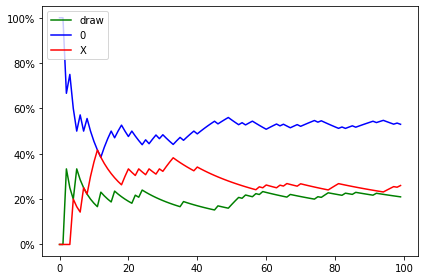

In [7]:
agent_vs_agent(env, DummyAgent, DummyAgent, n_episodes=100, params1={}, params2={}, plot=True)

### Question 2

Comment the results of random vs random above. How do you explain that 'O' has the advantage despite playing at random?

### Answer 2

## Monte Carlo Tree Search

A template class for MCTS is defined in mcts.py. It is an abstract class, and you need to instanciate the method search_heuristic, to guide the selection step of MCTS.

We first implement the uniform random search.

### Question 2

- Understand the pure exploration tree search heuristic implementation
- Implement the UCT algorithm

Feel free to experiment and implement other tree search policies (e.g., implement a pure exploitation tree search heuristic)

In [8]:
from mcts import MCTS

class MCTSPureExploration(MCTS):
    def __init__(self, player=1):
        super().__init__(player=player)

    def search_heuristic(self, node):
        """Pure exploration, uniformly choose how to
        explore the game tree.
        """
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        
        return np.random.choice(list(self.children[node]))


class MCTSUCT(MCTS):
    def __init__(self, player=1, exploration_param=1.0):
        self.exploration_param = exploration_param
        super().__init__(player=player)

    def search_heuristic(self, node):
        """Upper Confidence bound for Trees.
        Balance exploration and exploitation in the game tree.
        """
        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])
        
        # children is a dictionary of node -> set of children,
        # where node is a TicTacToeEnv, and the chidlren are
        # TicTacToeEnv corresponding to boards that are 
        # one action away from node.
        
        # self.W is a dictionary of node -> backpropagated rewards
        # self.N is a dictionary of node -> backpropagated number of visits
        
        ### TO IMPLEMENT

In [9]:
class MCTSAgent(Agent):
    """TicTacToe template agent that plays according to MCTS.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1}):
        self.env = env
        self.player = player  # index of the player
        self.n_playouts = params.get('n_playouts', 1)
        # To be implemented in child class
        self.game_tree = None 
        
    def play(self):
        """Syntax: play should be a metbod without argument
        except self.
        """
        # Need to copy environment, so that MCTS internal simulations
        # do not affect the game being played
        env_copy = deepcopy(env)
        for _ in range(self.n_playouts):
            self.game_tree.playout(env_copy)
        return self.game_tree.choose(env_copy)


class MCTSPureExplorationAgent(MCTSAgent):
    """TicTacToe agent that plays according to MCTS Pure Exploration.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1}):
        super().__init__(env=env, player=player, params=params)
        self.game_tree = MCTSPureExploration(player=player)

        
class MCTSUCTAgent(MCTSAgent):
    """TicTacToe agent that plays according to MCTS UCT.
    """
    def __init__(self, env, player=1, params={'n_playouts': 1, 'exploration_param': 1.0}):
        super().__init__(env=env, player=player, params=params)
        exploration_param = params.get('exploration_param', 1.0)
        self.game_tree = MCTSUCT(player=player, exploration_param=exploration_param)

### Manual play

In [10]:
env.reset()

agent1 = DummyAgent(env, player=1)
agent2 = MCTSUCTAgent(env, player=2, params={'n_playouts': 10, 'exploration_param': 1.0})

n_episodes = 10

for episode in range(n_episodes):
    done = False
    _ = env.reset()
    turn = 0

    while not done:
        if turn % 2 == 0:
            action = agent1.play()
        else:
            action = agent2.play()

        _, _, done, _ = env.step(action)

        turn += 1

        if done:
            break

    winner = env.board.check_state()
    if winner == DRAW:
        print("**      DRAW      **")
    elif winner == 1:
        print("**      O WINS      **")
    else:
        print("**      X WINS      **")

**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      X WINS      **
**      DRAW      **
**      X WINS      **
**      DRAW      **
**      DRAW      **


### Check MCTS tree

In [ ]:
game_tree = agent2.game_tree
children = game_tree.children
print('Total number of nodes: {}\n'.format(len(children)))
for node, successors in children.items():
    print('Node: {} wins, {} visits'.format(game_tree.W[node], game_tree.N[node]))
    node.render()
    for successor in successors:
        print('Child: {} wins, {} visits'.format(game_tree.W[successor], game_tree.N[successor]))
        successor.render()
    print('----------------------\n\n')

### AI vs AI

In [ ]:
agent_vs_agent(env, DummyAgent, MCTSPureExplorationAgent, n_episodes=10, params1={}, params2={'n_playouts': 20}, plot=True)
agent_vs_agent(env, DummyAgent, MCTSUCTAgent, n_episodes=10, params1={}, params2={'n_playouts': 20}, plot=True)

### Question 3

Compare with the Q-Learning algorithm you have seen in TD1.

Comment on the behaviour of Q-Learning.

To you, what are the advantages and disadvantages of Q-Learning compared to MCTS?

In [ ]:
from qlearning import QFunction, QLearningAgent, random_vs_Q_learning, Q_learning_vs_random

class QLearningAgent(Agent):
    """Dummy TicTacToe agent that plays randomly.
    """
    def __init__(self, env, player=1, params={'Q': None}):
        self._env = env
        self.player = player  # index of the player
        Q = params.get('Q', None)
        if Q is not None:
            self.Q = Q
        else:
            self.Q = QFunction(nbr_pos=env.nbr_pos)

    def play(self):
        """Syntax: play should be a metbod without argument
        except self.
        """
        return self.Q.get_argmax_action_Q_idx(self.env.state(), self.env)

In [ ]:
GAMMA = 0.99
n_episodes = int(1e4)
learning_rate = 0.1
epsilon_greedy = 0.9
epsilon_greedy_decay_freq = 50
epsilon_greedy_decay_factor = 0.9

Q_opt_Q_learning_cross, stats = random_vs_Q_learning(
    env,
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
    gamma=GAMMA,
)

Q_opt_Q_learning_nought, stats = Q_learning_vs_random(
    env,
    n_episodes,
    learning_rate,
    epsilon_greedy,
    epsilon_greedy_decay_freq,
    epsilon_greedy_decay_factor,
    gamma=GAMMA,
)

In [ ]:
agent_vs_agent(env, QLearningAgent, MCTSUCTAgent, n_episodes=10, params1={'Q': Q_opt_Q_learning_nought.Q}, params2={'n_playouts': 20}, plot=True)

# Practical Session 3 -  Best Arm Identification

### Question 0

Recall the `forban` module.

### Question 1

What are the three main parts of an exploration algorithm that aims to identify the best arm (*i.e.*, the arm having the largest mean).